## Importando as bibliotecas necessárias

In [10]:
!pip install tensorflow-gpu

In [11]:
import pandas as pd

import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import tensorflow as tf

import re

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Lendo os dados

In [12]:
data = pd.read_csv("/content/drive/MyDrive/nuveo/spam/TrainingSet/sms-hamspam-train.csv",sep="\t", error_bad_lines=False, names=['Spam','Text'])
data.head()

,Spam,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,spam,"SMSSERVICES. for yourinclusive text credits, p..."
2,spam,25p 4 alfie Moon's Children in need song on ur...
3,spam,U have a secret admirer. REVEAL who thinks U R...
4,spam,"Dear Voucher Holder, To claim this weeks offer..."


## Análise dos dados

Podemos ver que existem muito mais exemplos da classe `Not Spam`, classe indicando que o email não é um Spam, do que da classe `Spam`. Dessa forma, podemos realizar dois procedimentos: 
* `UnderSampling`, onde reduzimos o número de amostras de uma classe, para que o dataset fique mais balanceado;
* `OverSampling`, onde produzimos novas amostras da classe minoritária, para que o dataset fique mais balanceado;

Etnão vamos aplicar `OverSampling` que geralmente tem melhores resultados.

In [13]:
data.Spam.value_counts()

ham     4100
spam     625
Name: Spam, dtype: int64

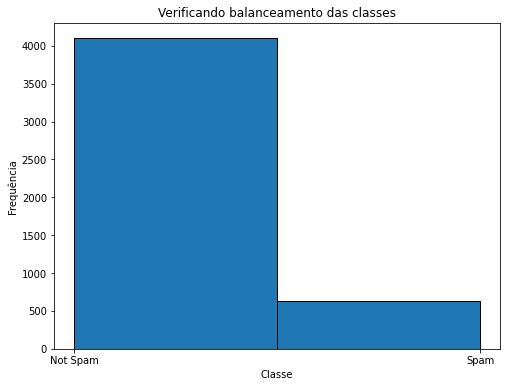

In [14]:
response = data["Spam"].apply(lambda res : "Not Spam" if res == 'ham' else "Spam")

plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(response, bins=2, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

## Pre-processamento dos dados

1.   Removendo as stopwords presentes e palavras com tamanho menor ou igual a 2;
2.   Deixando todas as palavras em minúsculo;
3.   Removendo termos que possuem dígitos;
4.   Limpeza de caracteres especiais e dígitos;
5.   Stemização dos dados para remoção de inflexões;

In [15]:
stop_words = set(stopwords.words("english"))
stemmer = nltk.stem.RSLPStemmer()
def cleanText(data):
  #construct a new list to store the cleaned text
  clean_text = []
  for (i, row) in data.iterrows():
      text = data['Text'][i]

      #remove special characters and digits
      text  = re.sub("(\\d|\\W)+|\w*\d\w*"," ", text)
      text = ' '.join(stemmer.stem(s.lower()) for s in text.split() if (not any(c.isdigit() for c in s)) and len(s) > 2 and s not in stop_words)

      clean_text.append(text)

  print(f'Exemplo de textos após o pré-processamento: \n {clean_text[5:10]}')

  return clean_text

In [16]:
clean_text = cleanText(data)

Exemplo de textos após o pré-processamento: 
 ['want anytim network mim text new vide phon fiv pound per week call reply delivery tomorrow', 'tried contact off new vide phon anytim network mim half pric rent camcord call reply delivery wed', 'last chanc claim worth discount vouch text ye savamob memb off mobil sub remov txt stop', 'urgent call landlin your complimentary ibiz holiday cash await collection sae box ppm', 'today off claim worth discount vouch text ye savamob memb off mobil sub unsub reply']


## Verorizador

Iremos utilizar o TFIDF vetorizer um método antigo mais robusto para lidar com esse tipo de problema.

In [17]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(
        min_df = 10,
        max_df = 0.5,
        max_features = None,
        stop_words = stop_words, 
        ngram_range = (1,3)
  )


def tfidf_transform(tfv, text):
  #transform
  vec_text = tfv.fit_transform(text)

  #returns a list of words.
  words = tfv.get_feature_names()

  print(f'Tamanho do vocabulário: {len(words)}')
  print(f'Listando alguns termos: {words[1:10]}')

  return vec_text, words

Podemos ver que o corpus possui um vocabulário com 826 palavras diferentes:

In [18]:
vec_title, words = tfidf_transform(tfv, clean_text)

Tamanho do vocabulário: 826
Listando alguns termos: ['abt', 'account', 'account statement', 'actually', 'addres', 'aft', 'afternoon', 'age', 'ago']


### Transformando as categorigas `ham` e `Spam`

Vamos converter as categorias em valores numéricos para poderem ser aplicadas nos algoritmos de classificação:

In [19]:
pd.Categorical(data.Spam).codes

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

## Separando os dados em treino e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(vec_title, pd.Series(pd.Categorical(data.Spam).codes), test_size=0.3)

## Aplicando OverSampling nos dados de treino

Após a divisão dos dados em treino e teste, vamos aplicar um `OverSampling` utilizando a biblioteca SMOTE. Esse procedimento foi realizado após a divisão dos dados pois os dados de teste precisam ter o desbalanceamento real.

In [21]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train,y_train)

y_sm = pd.Series(y_sm, name="Spam")
y_sm.value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    2883
0    2883
Name: Spam, dtype: int64

## Aplicando os modelos

Nesse estudo iremos aplicar dois modelos de classificação, um modelo mais simples (Logistic Regression) e um modelo mais robusto (RandomForest).

### Logistic Regression

Vamos utilizar validação cruzada com 10 `folds` para evitar overfitting do modelo e melhorar seus resultados. Além disso iremos aplicar diferentes parâmetros de treinamento `logreg_C` para avaliar diferentes modelos e escolher o com os melhores resultados.

In [22]:
folds = 10
kfold = StratifiedKFold(folds)

logreg_C = [1e-4, 1e-3, 1e-2, 0.5e-1, 1]
best_c = logreg_C[0]
best_score = 0
best_accuracy = 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    for train_index, test_index in kfold.split(X_sm, y_sm):
        x_train_fold, x_test_fold = X_sm[train_index], X_sm[test_index]
        y_train_fold, y_test_fold = y_sm.iloc[train_index], y_sm.iloc[test_index]

        lr = LogisticRegression(C=c, random_state=31, max_iter=300)
        lr.fit(x_train_fold, y_train_fold)
        pred = lr.predict(x_test_fold)

        score += f1_score(y_test_fold, pred, average='weighted')
        accuracy += accuracy_score(y_test_fold, pred)


    score = score / folds # média
    avg_scores.append(score)
    accuracy = accuracy / folds
    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 1. Resultou no F1 0.9333068415115822 e Acurácia 0.9333995282110534 durante o 10-fold


### Função para avaliação do modelo

In [23]:
def evaluate_model(model, data, y):
  pred = model.predict(data)

  f1 = f1_score(y, pred, average='weighted')
  accuracy = accuracy_score(y, pred)
  precision = precision_score(y, pred, average='weighted')
  recall = recall_score(y, pred, average='weighted')

  return (f1, accuracy, precision, recall, pred)

### Avaliando a qualidade do modelo

Obtivemos um resultado de 0.96, um ótimo resultado com um modelo relativamente simples. Ainda assim, vamos avaliar o `Random Forest` para vermos se obtivemos resultados ainda melhores.

In [24]:
train_f1, train_accuracy, train_precision, train_recall, pred_train = evaluate_model(lr, X_test, y_test)

print(f'O melhor modelo resultou um desempenho no treino de F1: {train_f1}, Acurácia: {train_accuracy}, Precisão: {train_precision}, Recall: {train_recall}')

O melhor modelo resultou um desempenho no treino de F1: 0.9680734773490777, Acurácia: 0.9675599435825106, Precisão: 0.9690309455667191, Recall: 0.9675599435825106


### Plotando a matriz de confusão

In [25]:
def plot_confusion_matrix(cm):
  plt.figure(figsize = (5,3))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

Podemos ver que o modelo pouco errou em identificar classes que são Spam como Spam, mas teve 35 casos em que não eram Spam e ele identificou como Spam, isso pode ser um problema, pois poderia se tratar de mensagens importantes para o usuário.

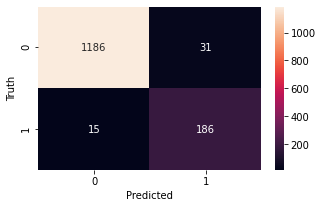

In [26]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=pred_train)
plot_confusion_matrix(cm)

## Random Forest

Com o modelo de RandomForest foi utilizado a função GridSearchCV para avaliar diferentes parâmetros do modelo.

In [27]:
rf = RandomForestClassifier(random_state=42)
rf_params = { 'max_depth': [10,15,25,35], 'max_leaf_nodes': [100,200,500,1000] }
grid = GridSearchCV(rf, rf_params, 'f1_weighted', cv=folds, n_jobs=n_jobs)
grid.fit(X_sm, y_sm)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

### Avaliando a qualidade do modelo

Obtivemos um resultado de 0.982, um resultado quase perfeito com o `Random Forest`. Por ser um modelo mais robusto, ele também requer mais processamento e ocupa mais espaço.

In [28]:
train_f1, train_accuracy, train_precision, train_recall, pred_train = evaluate_model(grid, X_test, y_test)

print(f'O melhor modelo resultou um desempenho no treino de F1: {train_f1}, Acurácia: {train_accuracy}, Precisão: {train_precision}, Recall: {train_recall}')

O melhor modelo resultou um desempenho no treino de F1: 0.978325771345709, Acurácia: 0.9788434414668548, Precisão: 0.9788223148938099, Recall: 0.9788434414668548


### Plotando a mamitrz de confusão

Nesse caso podemos ver que o erro nas duas classes está mais equilibrado.

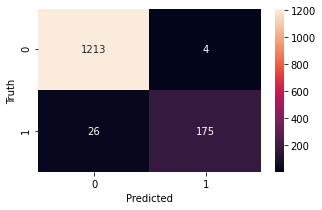

In [29]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=pred_train)
plot_confusion_matrix(cm)

## Evaluate model

Avaliando os dados de teste.

### Importando os dados

In [47]:
data = pd.read_csv("/content/drive/MyDrive/nuveo/spam/TestSet/sms-hamspam-test.csv",sep="\t", error_bad_lines=False, names=['Text'])
data.head()

,Text
0,I know that my friend already told that.
1,It took Mr owl 3 licks
2,Dunno y u ask me.
3,K.k:)advance happy pongal.
4,I know but you need to get hotel now. I just g...


### Tratamento dos dados

precisamos realizar as mesmas etapas realizadas nos dados de treino para classificar os dados de teste.

In [48]:
clean_text = cleanText(data)

Exemplo de textos após o pré-processamento: 
 ['know mallik sherawat yesterday find url', 'just got room soon put clock back til shouted everyon get realised wahay anoth hour bed', 'well littl tim thing good tim ahead', 'latest still scroung amm want giv new try', 'congratulatiom awarded vouch gift guaranteed fre entry wkly draw txt music tnc www ldew']


### Transformando os dados de texto em valores numéricos

In [49]:
matrix = tfv.transform(clean_text)

### Predizendo e apresentando as classificações

In [50]:
data.insert(0, 'Spam', pd.Series(grid.predict(matrix)))
data['Spam'] = data["Spam"].apply(lambda res : "ham" if res == 0 else "spam")
data.head(10)

,Spam,Text
0,ham,I know that my friend already told that.
1,ham,It took Mr owl 3 licks
2,ham,Dunno y u ask me.
3,ham,K.k:)advance happy pongal.
4,ham,I know but you need to get hotel now. I just g...
5,ham,Do you know what Mallika Sherawat did yesterda...
6,ham,Just got up. have to be out of the room very s...
7,ham,Do well :)all will for little time. Thing of g...
8,ham,"8 at the latest, g's still there if you can sc..."
9,spam,Congratulations ur awarded 500 of CD vouchers ...


### Salvando os dados


In [52]:
data.to_csv("/content/drive/MyDrive/nuveo/spam/Results/results.csv", header=False)